Using device: cuda
Loading datasets...
Classes found: ['cats', 'dogs', 'snakes']
Number of classes: 3
Train samples: 1050
Val samples: 225
Test samples: 225


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Class weights: tensor([1., 1., 1.], device='cuda:0')


100%|██████████| 13.6M/13.6M [00:00<00:00, 134MB/s]

Trainable parameters: 1,736,067
Total parameters: 2,588,419
TRAINING ROBUST MODEL (PyTorch - Single Stage)

Epoch 1/40
--------------------------------------------------



/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Batch 0/33, Loss: 2.1815, Acc: 21.88%
Batch 20/33, Loss: 1.0508, Acc: 47.32%
Train Loss: 1.1397, Train Acc: 54.10%
Val Loss: 0.2384, Val Acc: 94.22%
Learning Rate: 0.00010000
💾 New best model saved! Val Acc: 94.22%

Epoch 2/40
--------------------------------------------------
Batch 0/33, Loss: 0.7378, Acc: 75.00%
Batch 20/33, Loss: 0.2840, Acc: 81.10%
Train Loss: 0.4516, Train Acc: 81.90%
Val Loss: 0.1427, Val Acc: 95.11%
Learning Rate: 0.00010000
💾 New best model saved! Val Acc: 95.11%

Epoch 3/40
--------------------------------------------------
Batch 0/33, Loss: 0.5641, Acc: 78.12%
Batch 20/33, Loss: 0.2275, Acc: 87.95%
Train Loss: 0.3058, Train Acc: 88.57%
Val Loss: 0.1074, Val Acc: 94.67%
Learning Rate: 0.00010000

Epoch 4/40
--------------------------------------------------
Batch 0/33, Loss: 0.5362, Acc: 78.12%
Batch 20/33, Loss: 0.1923, Acc: 90.48%
Train Loss: 0.2199, Train Acc: 91.33%
Val Loss: 0.0912, Val Acc: 96.00%
Learning Rate: 0.00010000
💾 New best model saved! Val Acc

/tmp/ipykernel_36/2013604284.py:407: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


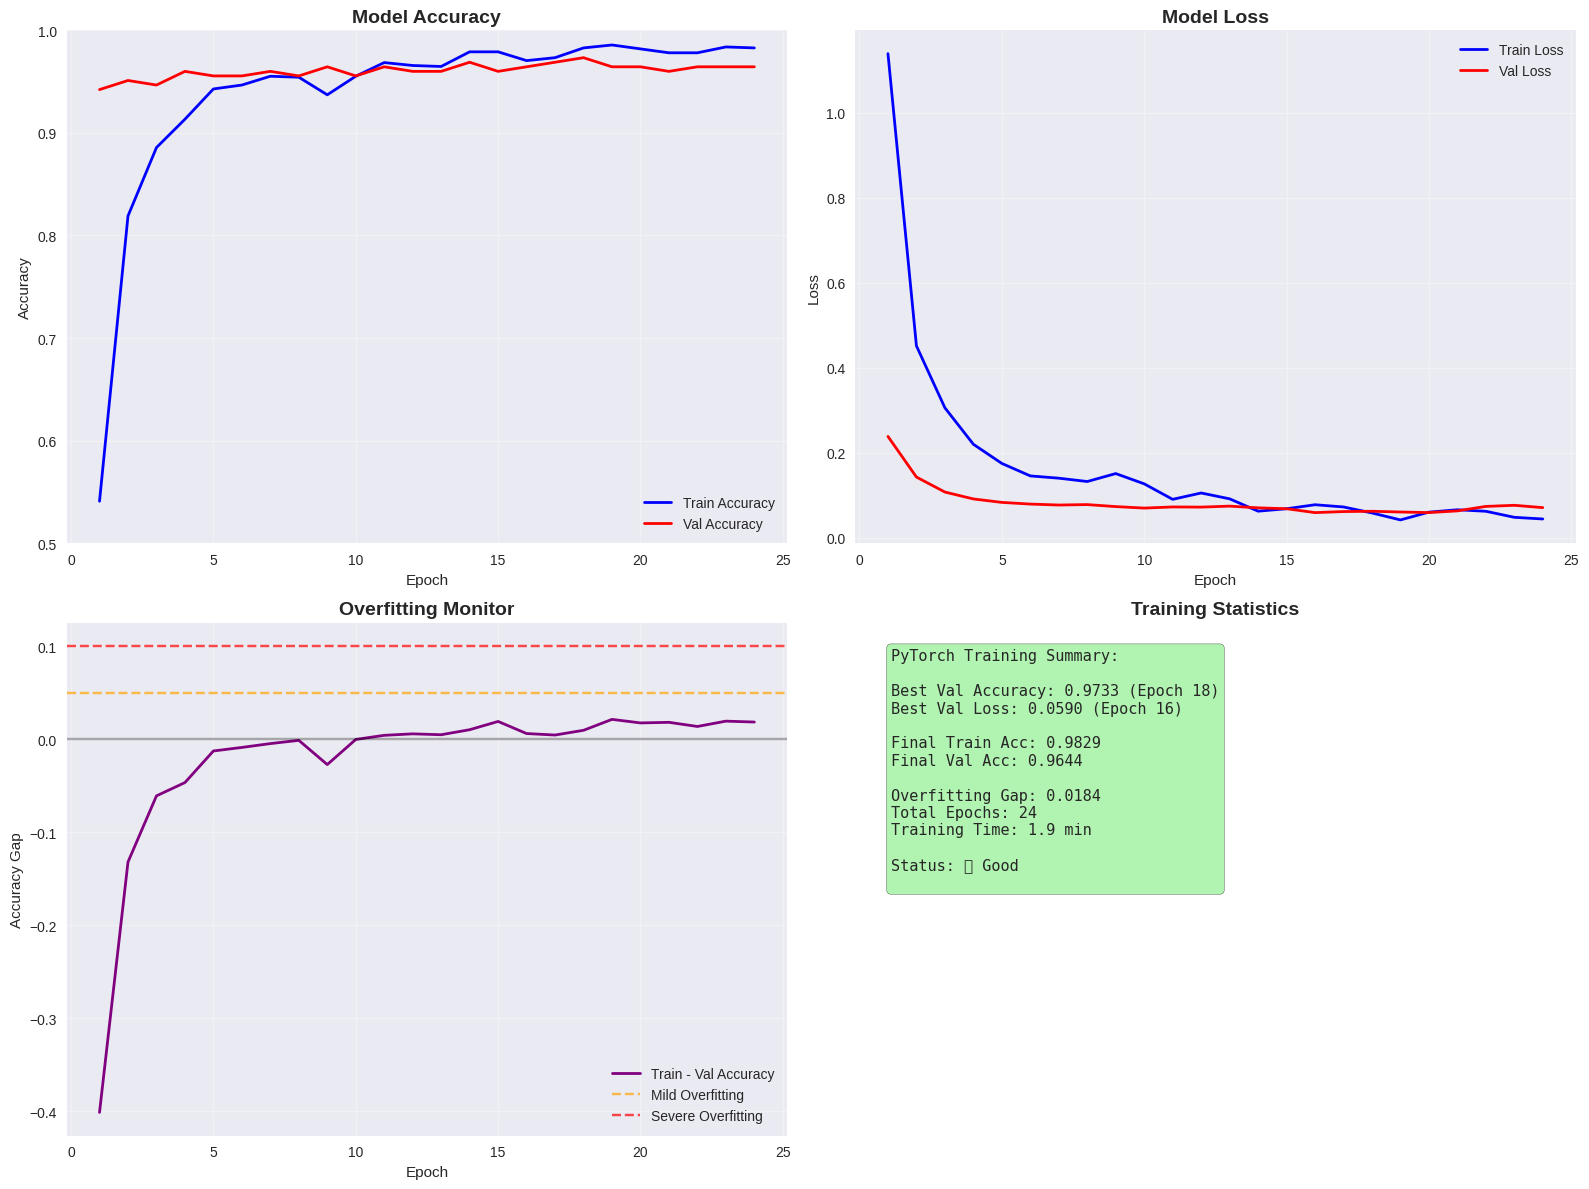


FINAL MODEL EVALUATION
Test Loss: 0.0532
Test Accuracy: 99.11%

Visualizing Predictions on Test Images:


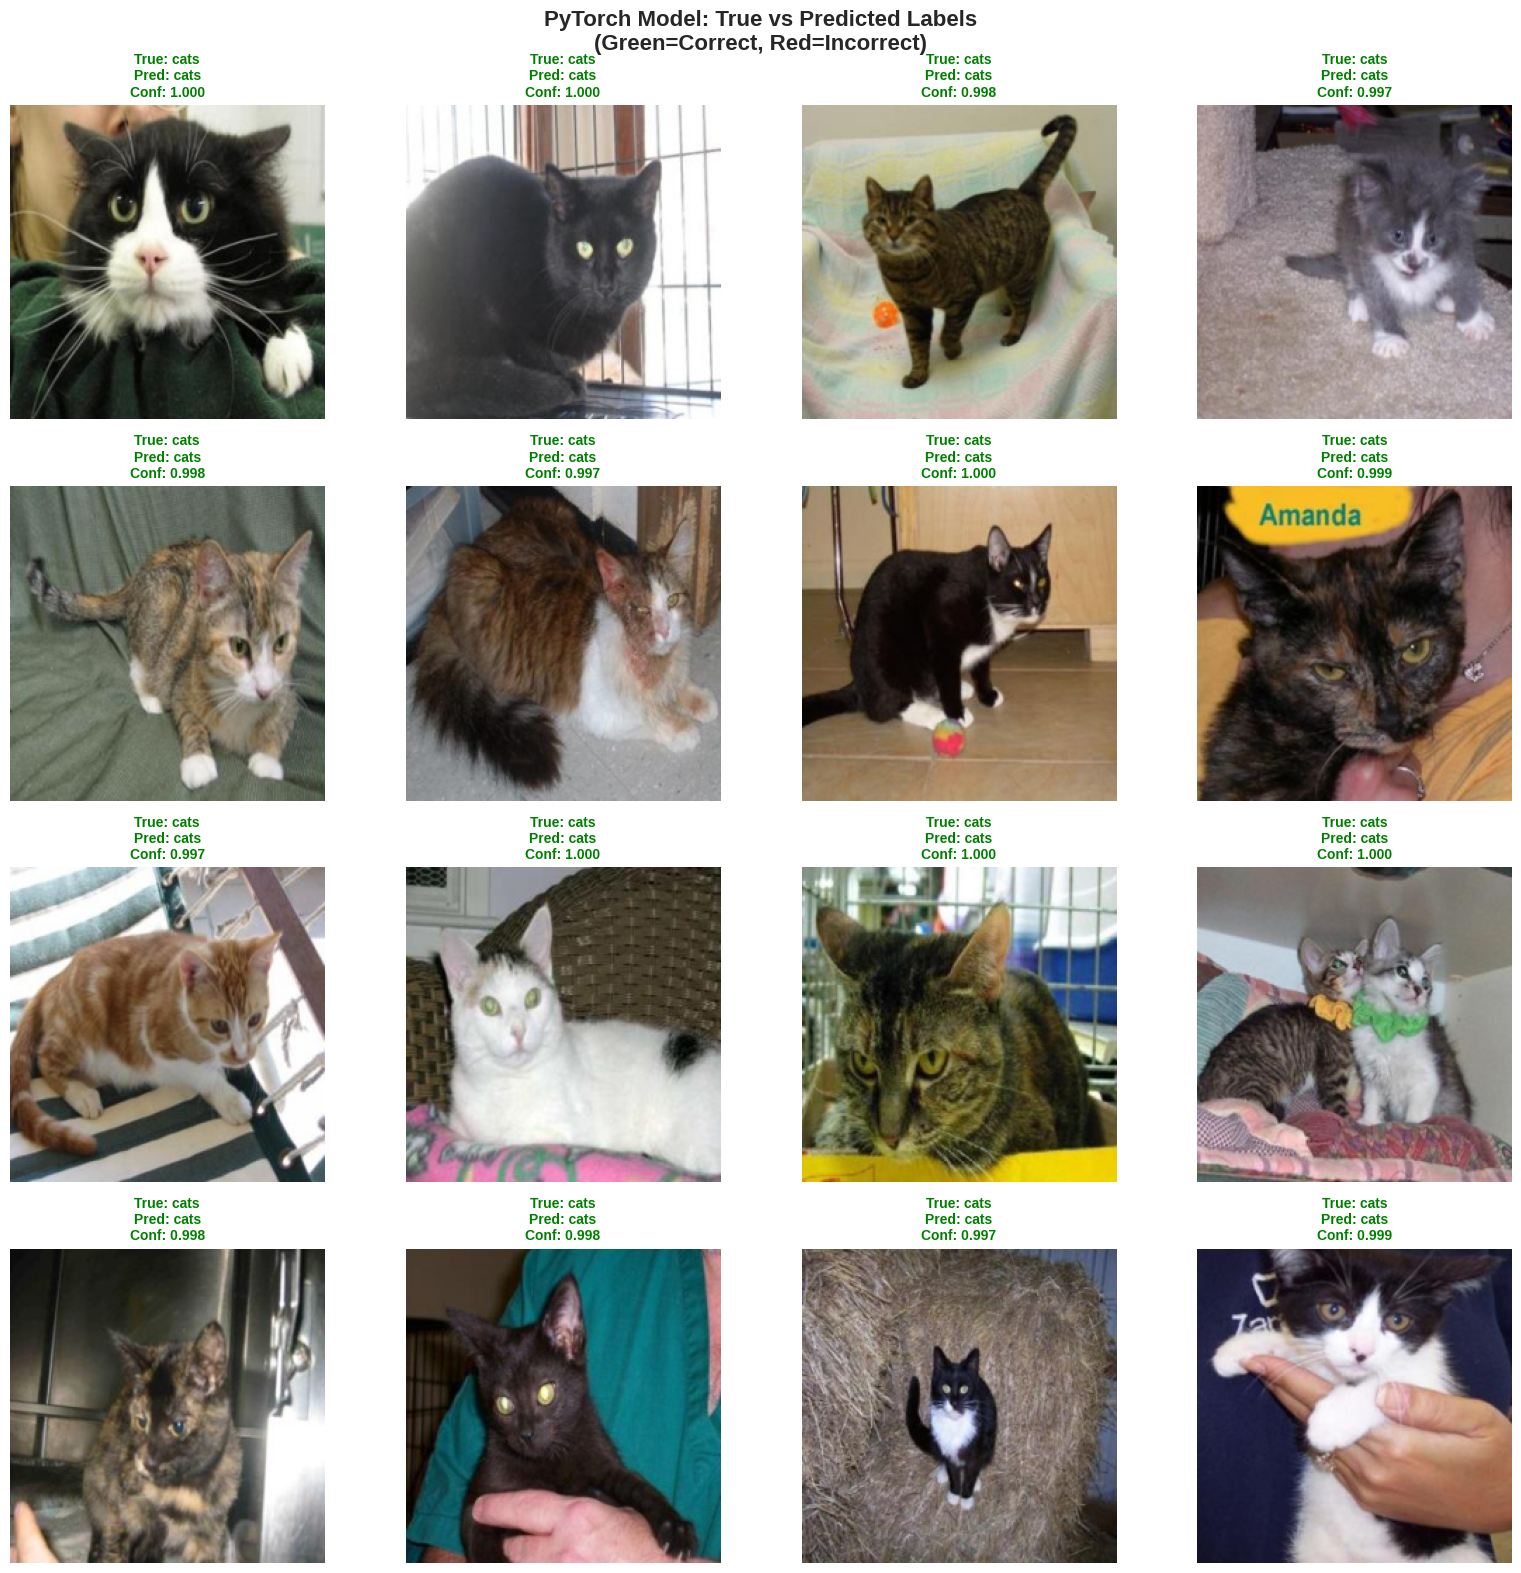

Batch Accuracy: 96.88%

Detailed Classification Report:
              precision    recall  f1-score   support

        cats     1.0000    0.9733    0.9865        75
        dogs     0.9740    1.0000    0.9868        75
      snakes     1.0000    1.0000    1.0000        75

    accuracy                         0.9911       225
   macro avg     0.9913    0.9911    0.9911       225
weighted avg     0.9913    0.9911    0.9911       225



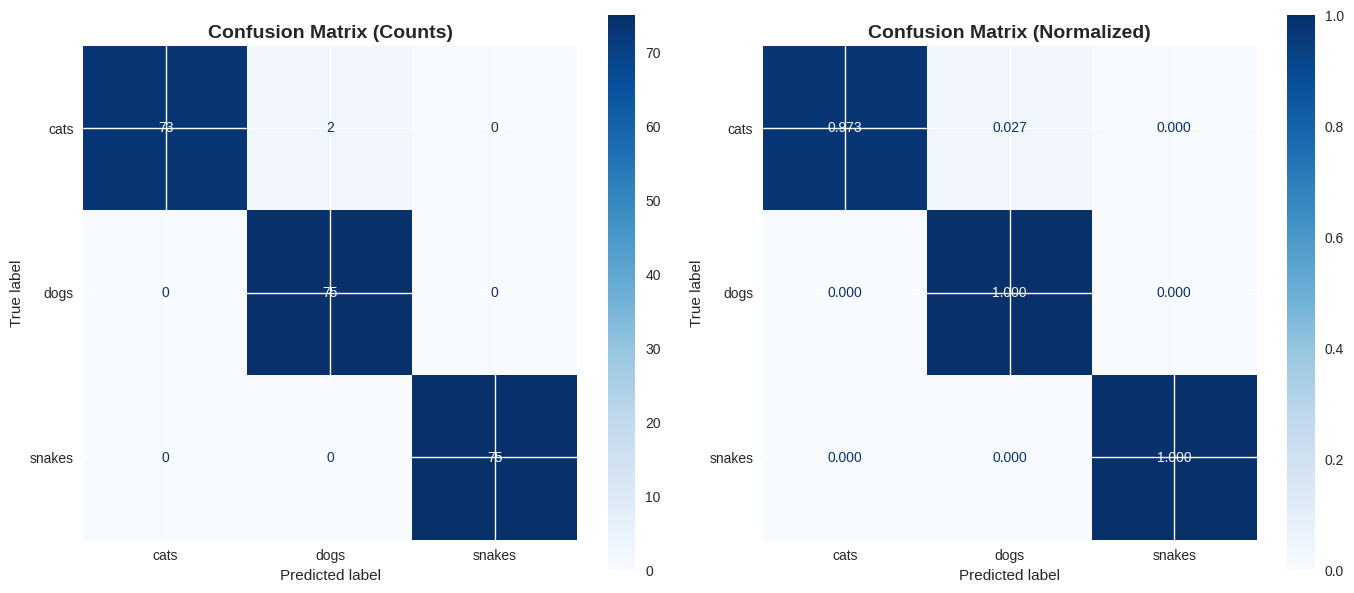


PYTORCH TRAINING COMPLETED!
Final Test Accuracy: 99.11%
Best Validation Accuracy: 97.33%
Overfitting Gap: 0.0184
Training Time: 1.93 minutes
Model saved as: robust_animal_classifier_pytorch.pth
Results saved as: pytorch_model_results.json
🎉 SUCCESS: PyTorch model achieved 96%+ accuracy!

HOW TO LOAD THE SAVED MODEL:

# To load the model later:
checkpoint = torch.load('robust_animal_classifier_pytorch.pth')
model = RobustAnimalClassifier(num_classes=3)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Class names and other info:
class_names = checkpoint['class_names']
test_accuracy = checkpoint['test_accuracy']



In [ ]:
# PyTorch Animal Classifier - Single Stage Robust Training
# Same logic as TensorFlow version but implemented in PyTorch

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import os
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import random
from PIL import Image
import json
from collections import defaultdict
import time

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Dataset Paths
dataset_path = "/kaggle/input/cats-dogs-snakes-images/animal_dataset"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

# 2. Custom Dataset Class
class AnimalDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        self.samples = []
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.samples.append((os.path.join(class_path, img_name), self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image if loading fails
            if self.transform:
                return self.transform(Image.new('RGB', (224, 224), (0, 0, 0))), label
            return Image.new('RGB', (224, 224), (0, 0, 0)), label

# 3. Data Transforms (Moderate Augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# For visualization (no normalization)
viz_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 4. Create Datasets and DataLoaders
print("Loading datasets...")
train_dataset = AnimalDataset(train_dir, transform=train_transform)
val_dataset = AnimalDataset(val_dir, transform=val_test_transform)
test_dataset = AnimalDataset(test_dir, transform=val_test_transform)
test_viz_dataset = AnimalDataset(test_dir, transform=viz_transform)  # For visualization

class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Classes found: {class_names}")
print(f"Number of classes: {num_classes}")
print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Calculate class weights
def get_class_weights(dataset):
    labels = [sample[1] for sample in dataset.samples]
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    return torch.FloatTensor(class_weights).to(device)

class_weights = get_class_weights(train_dataset)
print(f"Class weights: {class_weights}")

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_viz_loader = DataLoader(test_viz_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# 5. Define Robust Model
class RobustAnimalClassifier(nn.Module):
    def __init__(self, num_classes):
        super(RobustAnimalClassifier, self).__init__()

        # Load pretrained MobileNetV2
        self.backbone = models.mobilenet_v2(pretrained=True)

        # Freeze early layers, unfreeze last layers
        for param in list(self.backbone.parameters())[:-30]:
            param.requires_grad = False

        # Remove the original classifier
        self.backbone.classifier = nn.Identity()

        # Add custom classifier with strong regularization
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(1280),
            nn.Dropout(0.7),
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.backbone(x)
        output = self.classifier(features)
        return output

# Create model
model = RobustAnimalClassifier(num_classes).to(device)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,}")
print(f"Total parameters: {total_params:,}")

# 6. Loss Function and Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.02)  # L2 regularization

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.3, patience=5, min_lr=1e-8, verbose=True
)

# 7. Training Function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 20 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# 8. Validation Function
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# 9. Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=8, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

# 10. Training Loop
print("="*60)
print("TRAINING ROBUST MODEL (PyTorch - Single Stage)")
print("="*60)

# Initialize tracking
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

early_stopping = EarlyStopping(patience=8, min_delta=0.001)
best_val_acc = 0.0

num_epochs = 40
start_time = time.time()

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print epoch results
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%')
    print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.8f}')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, 'best_pytorch_model.pth')
        print(f'💾 New best model saved! Val Acc: {val_acc*100:.2f}%')

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Early stopping
    if early_stopping(val_loss, model):
        print(f'Early stopping triggered after {epoch+1} epochs')
        break

training_time = time.time() - start_time
print(f'\nTraining completed in {training_time/60:.2f} minutes')

# 11. Load Best Model
checkpoint = torch.load('best_pytorch_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")

# 12. Visualization Functions
def plot_training_history_pytorch(history):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    epochs = range(1, len(history['train_loss']) + 1)

    # Accuracy
    axes[0, 0].plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
    axes[0, 0].plot(epochs, history['val_acc'], 'r-', label='Val Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim([0.5, 1.0])

    # Loss
    axes[0, 1].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0, 1].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Overfitting Detection
    acc_diff = np.array(history['train_acc']) - np.array(history['val_acc'])
    axes[1, 0].plot(epochs, acc_diff, 'purple', linewidth=2, label='Train - Val Accuracy')
    axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[1, 0].axhline(y=0.05, color='orange', linestyle='--', alpha=0.7, label='Mild Overfitting')
    axes[1, 0].axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='Severe Overfitting')
    axes[1, 0].set_title('Overfitting Monitor', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy Gap')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Training Summary
    max_val_acc = max(history['val_acc'])
    max_val_epoch = history['val_acc'].index(max_val_acc) + 1
    final_train_acc = history['train_acc'][-1]
    final_val_acc = history['val_acc'][-1]
    min_val_loss = min(history['val_loss'])
    min_loss_epoch = history['val_loss'].index(min_val_loss) + 1

    summary_text = f"""PyTorch Training Summary:

Best Val Accuracy: {max_val_acc:.4f} (Epoch {max_val_epoch})
Best Val Loss: {min_val_loss:.4f} (Epoch {min_loss_epoch})

Final Train Acc: {final_train_acc:.4f}
Final Val Acc: {final_val_acc:.4f}

Overfitting Gap: {final_train_acc - final_val_acc:.4f}
Total Epochs: {len(epochs)}
Training Time: {training_time/60:.1f} min

Status: {'✅ Good' if final_train_acc - final_val_acc < 0.05 else '⚠️ Overfitting'}
    """

    axes[1, 1].text(0.05, 0.95, summary_text, transform=axes[1, 1].transAxes,
                   fontsize=11, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.7))
    axes[1, 1].set_xlim([0, 1])
    axes[1, 1].set_ylim([0, 1])
    axes[1, 1].axis('off')
    axes[1, 1].set_title('Training Statistics', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_training_history_pytorch(history)

# 13. Test Evaluation
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []
    test_loss = 0.0

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)

            test_loss += nn.CrossEntropyLoss()(outputs, targets).item()

            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    test_loss /= len(test_loader)
    test_acc = np.mean(np.array(all_preds) == np.array(all_targets))

    return test_loss, test_acc, all_targets, all_preds, np.array(all_probs)

print("\n" + "="*60)
print("FINAL MODEL EVALUATION")
print("="*60)

test_loss, test_acc, y_true, y_pred, y_pred_proba = evaluate_model(model, test_loader, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# 14. Visual Testing with True vs Predicted Labels
def visualize_predictions_pytorch(model, viz_loader, processed_loader, class_names, device, num_samples=16):
    """Visualize predictions with true vs predicted labels"""
    model.eval()

    # Get original images and processed images
    viz_iter = iter(viz_loader)
    proc_iter = iter(processed_loader)

    viz_batch = next(viz_iter)
    proc_batch = next(proc_iter)

    viz_images, viz_labels = viz_batch
    proc_images, proc_labels = proc_batch

    # Get predictions
    with torch.no_grad():
        proc_images = proc_images.to(device)
        outputs = model(proc_images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)

        predicted = predicted.cpu().numpy()
        probs = probs.cpu().numpy()
        confidence_scores = np.max(probs, axis=1)

    # Create visualization
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.ravel()

    for i in range(min(num_samples, len(viz_images))):
        # Display image (denormalize for visualization)
        img = viz_images[i].permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)  # Ensure values are in [0,1]
        axes[i].imshow(img)
        axes[i].axis('off')

        # Get labels
        true_label = class_names[viz_labels[i]]
        pred_label = class_names[predicted[i]]
        confidence = confidence_scores[i]

        # Color coding: Green for correct, Red for incorrect
        is_correct = viz_labels[i] == predicted[i]
        color = 'green' if is_correct else 'red'

        # Create title
        title = f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}"
        axes[i].set_title(title, fontsize=10, color=color, fontweight='bold')

    plt.suptitle("PyTorch Model: True vs Predicted Labels\n(Green=Correct, Red=Incorrect)",
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print accuracy for this batch
    batch_accuracy = np.mean(viz_labels.numpy() == predicted)
    print(f"Batch Accuracy: {batch_accuracy*100:.2f}%")

print("\nVisualizing Predictions on Test Images:")
print("="*50)
visualize_predictions_pytorch(model, test_viz_loader, test_loader, class_names, device, num_samples=16)

# 15. Classification Report and Confusion Matrix
print("\nDetailed Classification Report:")
print("="*50)
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cm = confusion_matrix(y_true, y_pred)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title("Confusion Matrix (Counts)", fontsize=14, fontweight='bold')

cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)
disp2.plot(ax=axes[1], cmap='Blues', values_format='.3f')
axes[1].set_title("Confusion Matrix (Normalized)", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# 16. Save Final Model as .pth File
final_model_path = 'robust_animal_classifier_pytorch.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
    'num_classes': num_classes,
    'test_accuracy': test_acc,
    'test_loss': test_loss,
    'best_val_accuracy': max(history['val_acc']),
    'model_architecture': 'MobileNetV2_Custom_Classifier',
    'training_history': history
}, final_model_path)

# Save metadata
pytorch_results = {
    'class_names': class_names,
    'num_classes': num_classes,
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss),
    'best_val_accuracy': float(max(history['val_acc'])),
    'total_epochs': len(history['train_loss']),
    'trainable_parameters': trainable_params,
    'total_parameters': total_params,
    'training_time_minutes': training_time / 60,
    'device_used': str(device),
    'overfitting_gap': float(history['train_acc'][-1] - history['val_acc'][-1]),
    'approach': 'pytorch_single_stage_mobilenetv2'
}

with open('pytorch_model_results.json', 'w') as f:
    json.dump(pytorch_results, f, indent=2)

print(f"\n" + "="*60)
print("PYTORCH TRAINING COMPLETED!")
print("="*60)
print(f"Final Test Accuracy: {test_acc * 100:.2f}%")
print(f"Best Validation Accuracy: {max(history['val_acc']) * 100:.2f}%")
print(f"Overfitting Gap: {pytorch_results['overfitting_gap']:.4f}")
print(f"Training Time: {training_time/60:.2f} minutes")
print(f"Model saved as: {final_model_path}")
print(f"Results saved as: pytorch_model_results.json")

if test_acc >= 0.96:
    print(f"🎉 SUCCESS: PyTorch model achieved 96%+ accuracy!")
else:
    print(f"📈 Current PyTorch accuracy: {test_acc*100:.2f}%")

# 17. How to Load the Model Later
print(f"\n" + "="*40)
print("HOW TO LOAD THE SAVED MODEL:")
print("="*40)
print("""
# To load the model later:
checkpoint = torch.load('robust_animal_classifier_pytorch.pth')
model = RobustAnimalClassifier(num_classes=3)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Class names and other info:
class_names = checkpoint['class_names']
test_accuracy = checkpoint['test_accuracy']
""")